# Compare ocean dynamics (zos) from CMIP5 and CMIP6 with sea level budgets

In [42]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

sys.path.append('../code/')
import mod_loc as loc
import mod_postpro as pp

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [18]:
import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True})

In [28]:
cmip_data_dir = '../outputs/'

path_fig = ('/Users/dewilebars/Projects/KNMIClimateScenarios2021-2023/KNMI21/'+
            'projections/figures/')

In [20]:
path_slb = '/Users/dewilebars/Projects/SLBudget/outputs/'
budget_df = pd.read_csv(path_slb+
                        'slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
budget_df = budget_df.set_index('time')
budget_df.iloc[-10:]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
2009,8.016171,3.552064,2.508173,1.105000,1.194167,0.370833,0.088333,0.188333,0.892339,-1.090116,-0.792955,5.600000
2010,8.003000,4.389224,2.463398,1.141833,1.259167,0.446667,0.100833,0.367500,0.735257,-2.354945,-0.545934,4.766667
2011,9.988545,4.781370,2.577349,1.178667,1.286667,0.466667,0.103333,-0.016667,0.555900,1.935137,-2.879877,8.250000
2012,7.799622,2.654583,2.741227,1.215500,1.289167,0.491667,0.115833,0.316667,0.374518,0.184546,-1.584085,7.300000
2013,5.084063,3.520389,2.934533,1.252333,1.345833,0.561667,0.125000,0.511667,0.211591,-3.656733,-1.722219,4.800000
2014,8.918411,4.540554,3.090276,1.289167,1.401667,0.626667,0.130833,0.240000,0.085516,-2.865864,0.379595,8.900000
2015,10.947002,3.255820,3.297743,1.326000,1.474167,0.721667,0.144167,0.465000,0.010529,3.470097,-3.218186,11.483333
2016,7.910991,3.790802,3.270519,1.362833,1.528333,0.692500,0.157500,0.675000,-0.004905,-1.330948,-2.230644,9.933333
2017,13.661746,5.137556,3.428105,1.399667,1.600000,0.708333,0.165000,0.130833,0.040957,3.277656,-2.226363,13.450000


In [21]:
budget_LocOcean = (budget_df['LocSteric'] + budget_df['Nodal'] + 
                   budget_df['Wind'] +  budget_df['Pressure'])
budget_LocOcean = budget_LocOcean - budget_LocOcean.loc[1986:2005].mean()

budget_LocSteric_Wind = (budget_df['LocSteric'] + budget_df['Wind'])
budget_LocSteric_Wind = (budget_LocSteric_Wind 
                         - budget_LocSteric_Wind.loc[1986:2005].mean())


In [22]:
cmip5_zos = pp.read_zos_ds(cmip_data_dir, 'cmip5', 'rcp85')
cmip5_zos = loc.rotate_longitude(cmip5_zos, 'lon')
cmip6_zos = pp.read_zos_ds(cmip_data_dir, 'cmip6', 'ssp585')

In [24]:
#regions: dutch_coast, north_sea, knmi14_reg
lon_min, lon_max, lat_min, lat_max = pp.define_area('knmi14_reg')

cmip6_df = pp.ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)
cmip5_df = pp.ds2df(cmip5_zos, lon_min, lon_max, lat_min, lat_max, 1979, 2030)

/Users/dewilebars/anaconda3/envs/p39ds/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [25]:
cmip6_mean_df = cmip6_df.mean(axis=1)
cmip5_mean_df = cmip5_df.mean(axis=1)

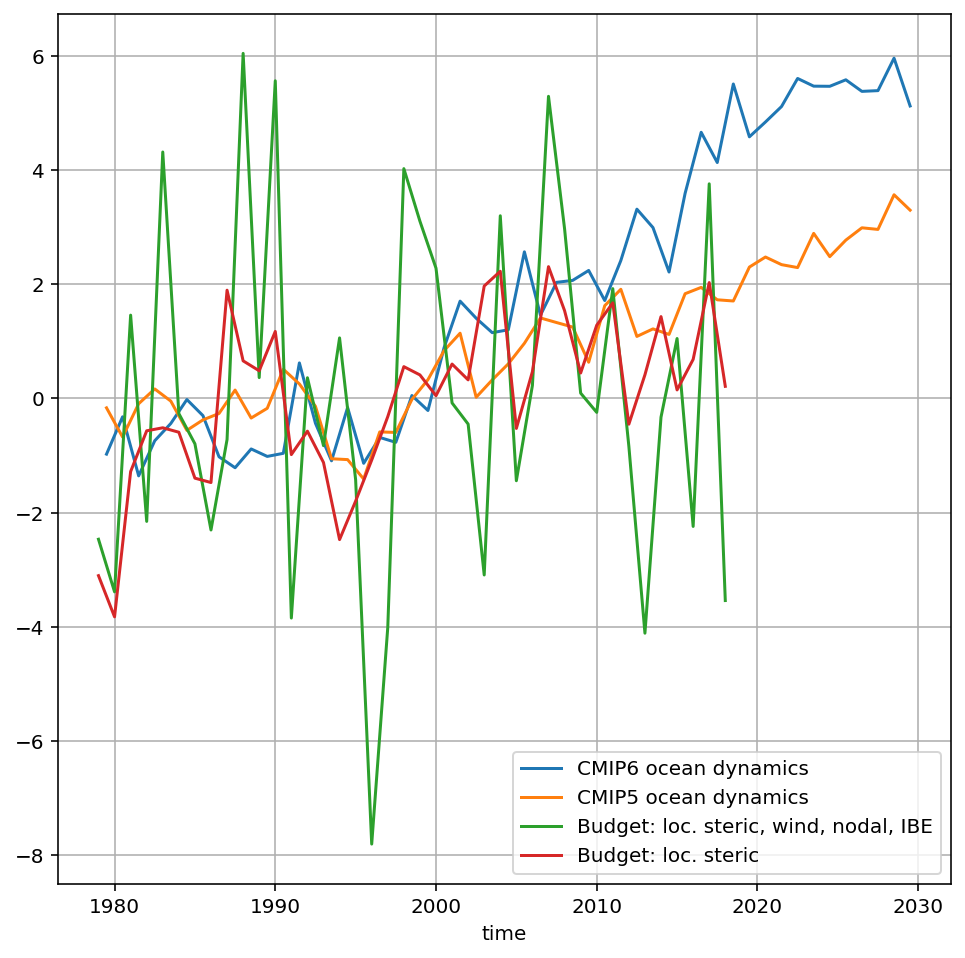

In [32]:
fig, ax = plt.subplots(figsize=(8,8))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.grid(True)

#plt.savefig(path_fig+'comp_ocean_dynamics.pdf', dpi=150)

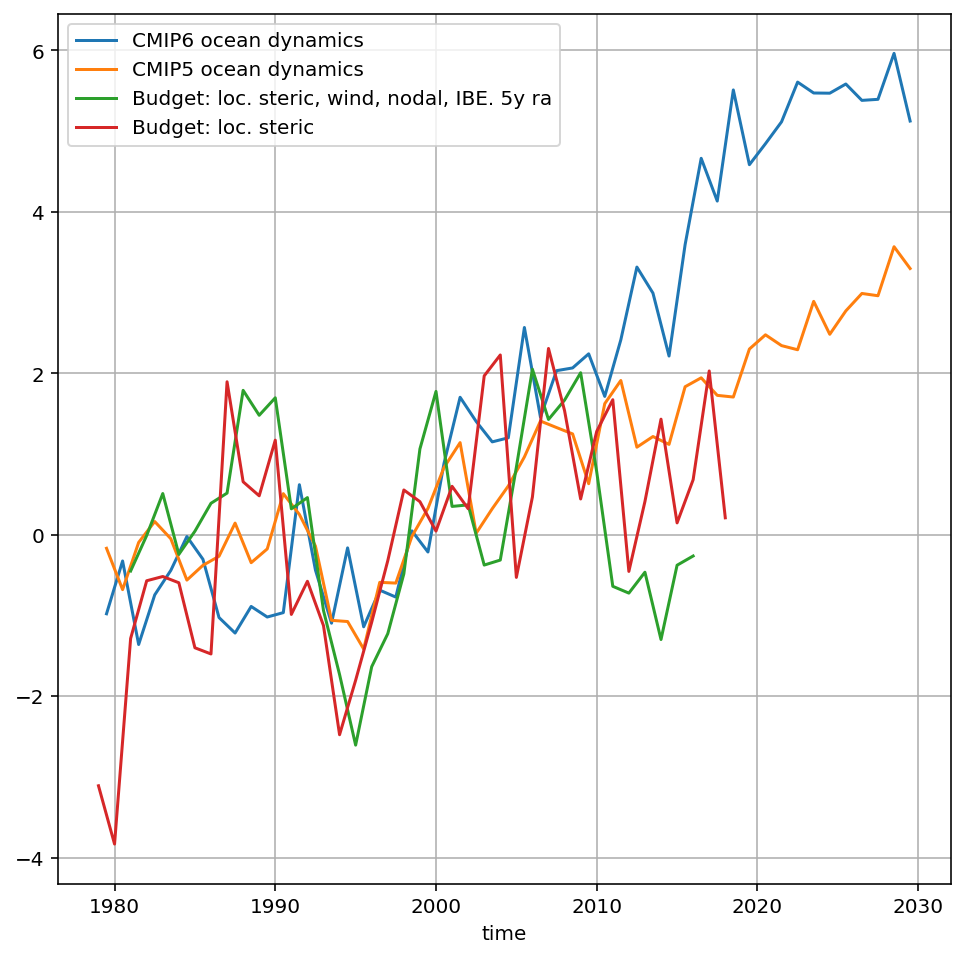

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

cmip6_mean_df.plot(legend=True, label='CMIP6 ocean dynamics')
cmip5_mean_df.plot(legend=True, label='CMIP5 ocean dynamics')
budget_LocOcean.rolling(5, center=True).mean().plot(legend=True, label='Budget: loc. steric, wind, nodal, IBE. 5y ra')
(budget_df['LocSteric']- budget_df['LocSteric'].loc[1986:2005].mean() ).plot(legend=True, label='Budget: loc. steric')

ax.grid(True)

plt.savefig(path_fig+'comp_ocean_dynamics_smoother.pdf', dpi=150)

### Compute the mismatch between CMIP6 and observations

In [36]:
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_LocSteric_Wind.loc[start_y:end_y], 1)[0]
trend_LocSteric_Wind

-0.00714455457256856

In [37]:
trend_LocSteric = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['LocSteric'].loc[start_y:end_y], 1)[0]
trend_LocSteric

0.04916121434215942

In [38]:
trend_Wind = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['Wind'].loc[start_y:end_y], 1)[0]
trend_Wind

-0.05630576891472801

In [39]:
trend_Press = np.polyfit(np.arange(start_y,end_y+1), 
                           budget_df['Pressure'].loc[start_y:end_y], 1)[0]
trend_Press

0.00960994693128683

In [40]:
cmip6_mean_df[2014.5] = cmip6_mean_df[2013.5]+cmip6_mean_df[2015.5]/2
trend_zos_cmip6 = np.polyfit(np.arange(start_y,end_y+1), 
                           cmip6_mean_df.loc[start_y:end_y+1], 1)[0]
trend_zos_cmip6

0.190504811952533

In [43]:
# Compute the bias arising from the mismatch between observed and modelled dynamics
start_y = 1979 #1986 #1979
end_y = 2018

bias_dynamics = linregress(np.arange(start_y,end_y+1), 
                 cmip6_mean_df.loc[start_y:end_y+1].values-
                 budget_LocSteric_Wind.loc[start_y:end_y].values)
print(f'The linear trend bias (in mm/year) for the period {start_y}-{end_y} is:')
print(bias_dynamics.slope*10)
print(f'with an standard error:')
print(bias_dynamics.stderr*10)

The linear trend bias (in mm/year) for the period 1979-2018 is:
1.2941115095235878
with an standard error:
0.42643143247588916


In [44]:
start_y = 1986 #1986 #1979
end_y = 2018

bias_dynamics = linregress(np.arange(start_y,end_y+1), 
                 cmip6_mean_df.loc[start_y:end_y+1].values-
                 budget_LocSteric_Wind.loc[start_y:end_y].values)
print(f'The linear trend bias (in mm/year) for the period {start_y}-{end_y} is:')
print(bias_dynamics.slope*10)
print(f'with an standard error:')
print(bias_dynamics.stderr*10)

The linear trend bias (in mm/year) for the period 1986-2018 is:
1.976493665251138
with an standard error:
0.5511665973725637


In [45]:
# Now instead of a linear trend bias, we compute a scaling factor
start_y = 1979 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = linregress(np.arange(start_y,end_y+1), 
                                   budget_LocSteric_Wind.loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind and loc steric (mm/year) is:')
print(trend_LocSteric_Wind*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric_Wind/trend_zos_cmip6)


Trend in observed wind and loc steric (mm/year) is:
0.1795925945072069
Trend in CMIP6 zos is:
1.4737041040307943
Scaling factor:
0.12186475834327606


In [46]:
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric_Wind = linregress(np.arange(start_y,end_y+1), 
                                   budget_LocSteric_Wind.loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind and loc steric (mm/year) is:')
print(trend_LocSteric_Wind*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric_Wind/trend_zos_cmip6)

Trend in observed wind and loc steric (mm/year) is:
-0.07144554572574614
Trend in CMIP6 zos is:
1.9050481195253923
Scaling factor:
-0.037503276160575666


In [47]:
# Scaling factor assuming wind in observations is due to natural variability
start_y = 1979 #1986 #1979
end_y = 2018

trend_LocSteric = linregress(np.arange(start_y,end_y+1), 
                        budget_df['LocSteric'].loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind (mm/year) is:')
print(trend_LocSteric*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric/trend_zos_cmip6)

Trend in observed wind (mm/year) is:
0.7287594874781527
Trend in CMIP6 zos is:
1.4737041040307943
Scaling factor:
0.49450869104923423


In [48]:
# Scaling factor assuming wind in observations is due to natural variability
start_y = 1986 #1986 #1979
end_y = 2018

trend_LocSteric = linregress(np.arange(start_y,end_y+1), 
                        budget_df['LocSteric'].loc[start_y:end_y]).slope
trend_zos_cmip6 = linregress(np.arange(start_y,end_y+1), 
                              cmip6_mean_df.loc[start_y:end_y+1]).slope

print('Trend in observed wind (mm/year) is:')
print(trend_LocSteric*10)

print('Trend in CMIP6 zos is:')
print(trend_zos_cmip6*10)

print(f'Scaling factor:')
print(trend_LocSteric/trend_zos_cmip6)

Trend in observed wind (mm/year) is:
0.49161214342158444
Trend in CMIP6 zos is:
1.9050481195253923
Scaling factor:
0.2580575988516555
